In [1]:
import os
import json
import torch


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from utils import common

## Basic Analysis
We have to find the best models for the following configurations

For raw audio:
Audio:True, Features: Raw
Audio:True, Features: MS

For rhythm:
Audio:False, Features: Raw
Audio:False, Features: Raw

In [2]:
def max_epoch(results_dir, model_id):
    epochs = os.listdir(os.path.join(results_dir, model_id, "epochs"))
    epochs = map(lambda _: int(_.split("_")[0]), epochs)
    return max(epochs)

In [3]:
def read_results(results_dir):
    model_ids = {m for m in os.listdir(results_dir)}
    
    # read in the metrics
    confusion_matrices = {}
    metrics = {}
    for model_id in model_ids:
        last_epoch = max_epoch(results_dir, model_id)
        confusion_matrices[model_id] = []
        metrics[model_id]= []
        for i in range(0, last_epoch + 1):
            cm = {}
            m = {}
            for split in {"train", "val"}:
                cm[split] = np.load(os.path.join(results_dir, model_id, "confusion_matrix", f"{i}_{split}_metrics.npy"))
                m[split] = torch.load(os.path.join(results_dir, model_id, "epochs", f"{i}_{split}_metrics.pkl"))

            confusion_matrices[model_id].append(cm)
            metrics[model_id].append(m)
    
    return model_ids, confusion_matrices, metrics

In [4]:
def split_to_experiments(model_ids, metrics):
    audio_raw = set()
    audio_ms = set()
    rhythm_raw = set()
    rhythm_ms = set()
    for m in model_ids:
        if m.startswith("audioTrue"):
            if "featuresraw" in m:
                audio_raw.add(m)
            else:
                audio_ms.add(m)
        else:
            if "featuresraw" in m:
                rhythm_raw.add(m)
            else:
                rhythm_ms.add(m)
    
    # within each of the models, pick the best performing one based on the validation f1

    # top level dict for easier looping
    models = {"audio,raw": audio_raw, "audio,ms": audio_ms, "rhythm,raw": rhythm_raw, "rhythm,ms": rhythm_ms}
    best_models = {}
    for name, m_ids in models.items():
        all_models = {}
        for m in m_ids:
            epoch_metrics = metrics[m]
            epoch_f1 = list(map(lambda _: _["val"]["micro avg"]["f1-score"], epoch_metrics))
            all_models[m] = max(epoch_f1)

        best_model = max(all_models, key=lambda _: all_models[_])
        print(f"Best model for {name} is : {best_model}, with a F1 of {all_models[best_model]}")
        best_models[name] = best_model
    
    return best_models

In [5]:
def analyze(results_dir):
    model_ids, confusion_matrices, metrics = read_results(results_dir)
    
    best_models = split_to_experiments(model_ids, metrics)
        
    # visualize the loss + F1 for each model
    for name, model_id in best_models.items():

        epoch_metrics = metrics[model_id]
        epoch_train_f1 = list(map(lambda _: _["train"]["micro avg"]["f1-score"], epoch_metrics))
        epoch_val_f1 = list(map(lambda _: _["val"]["micro avg"]["f1-score"], epoch_metrics))
        epoch_val_loss = list(map(lambda _: _["val"]["epoch_loss"], epoch_metrics))
        epoch_train_loss = list(map(lambda _: _["train"]["epoch_loss"], epoch_metrics))

        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax1.plot(epoch_train_loss, label="Train Loss")
        ax1.plot(epoch_val_loss, label="Val Loss")
        ax1.legend()
        ax1.set_title("Losses")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")


        ax2 = fig.add_subplot(122)
        ax2.plot(epoch_train_f1, label="Val F1 (Micro Avg)")
        ax2.plot(epoch_val_f1, label="Val F1 (Micro Avg)")
        ax2.legend()
        ax2.set_title("F1 Scores")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("F1 Score")


        plt.suptitle(f"Performance Metrics for best model: {name}")

        fig.savefig(f"{results_dir}_{name}_{model_id}_perf.png")


Best model for audio,raw is : audioTrue_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.651027027027027
Best model for audio,ms is : audioTrue_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.696
Best model for rhythm,raw is : audioFalse_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6637837837837838
Best model for rhythm,ms is : audioFalse_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6408648648648648


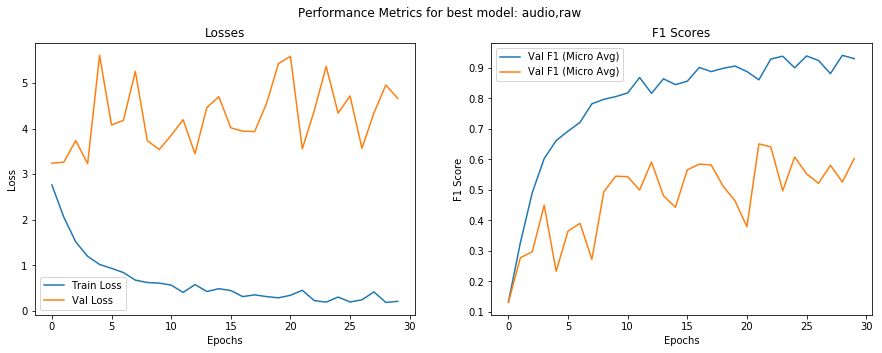

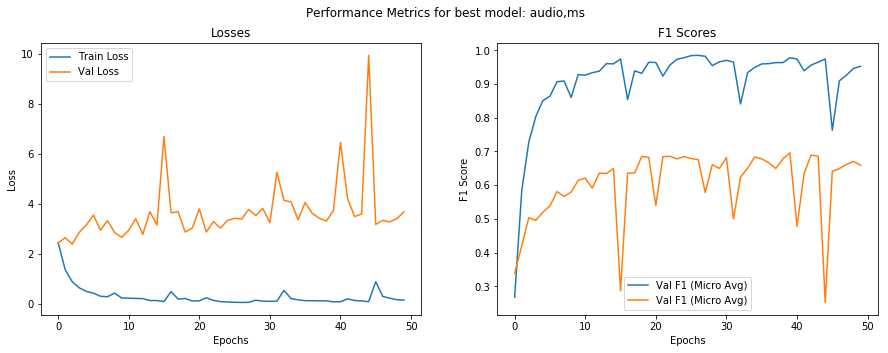

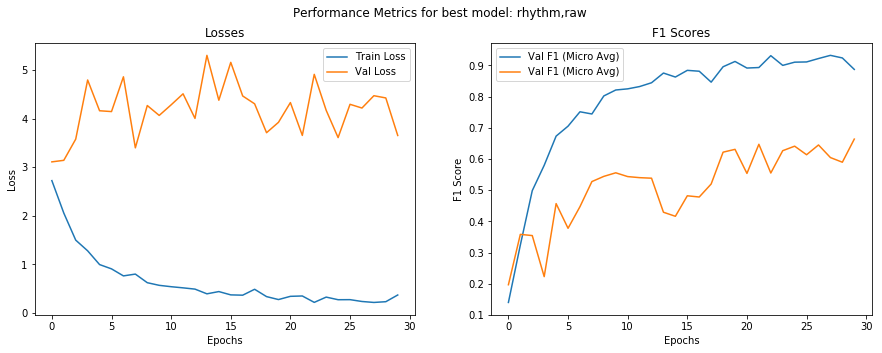

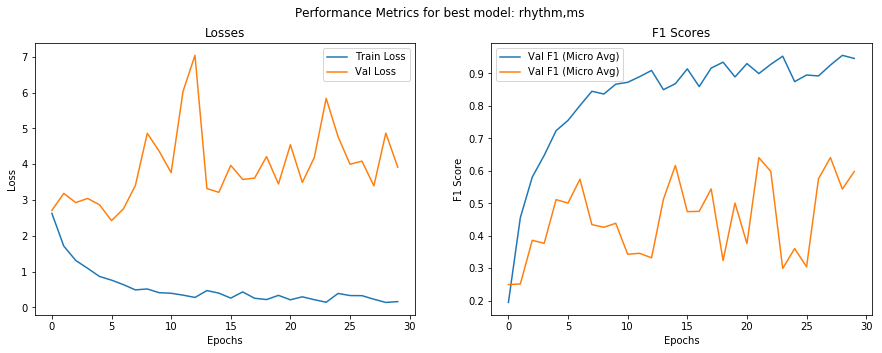

In [6]:
analyze("results_no_weight_decay")

Best model for audio,raw is : audioTrue_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6566486486486487
Best model for audio,ms is : audioTrue_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6964324324324325
Best model for rhythm,raw is : audioFalse_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6371891891891892
Best model for rhythm,ms is : audioFalse_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6


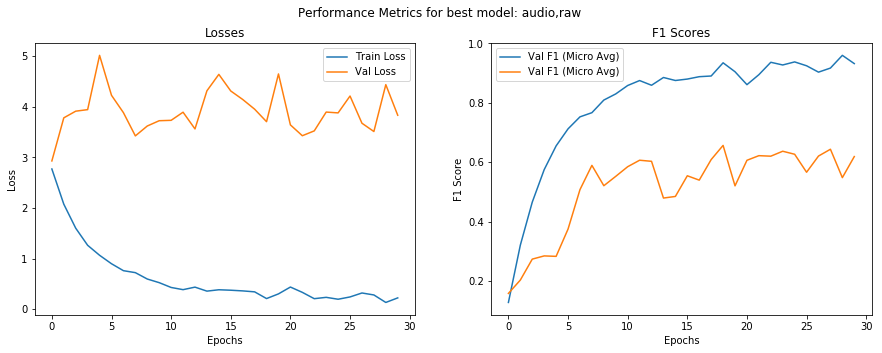

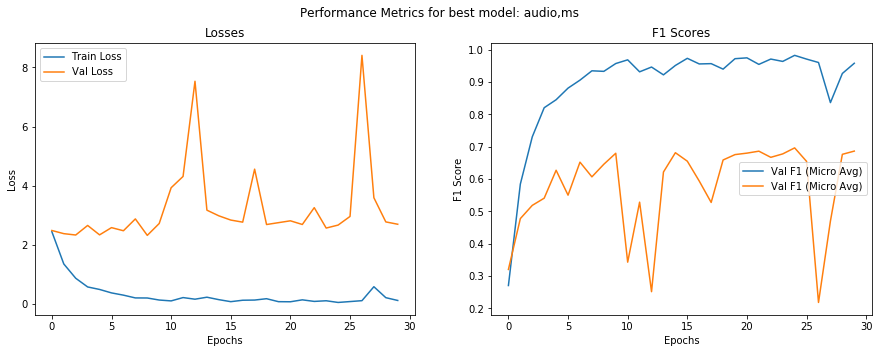

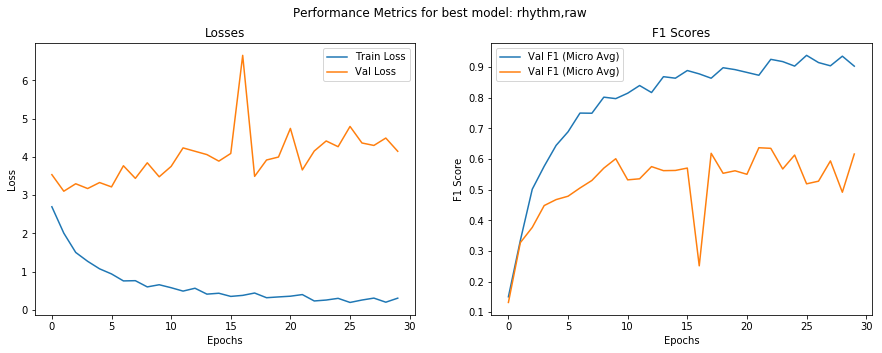

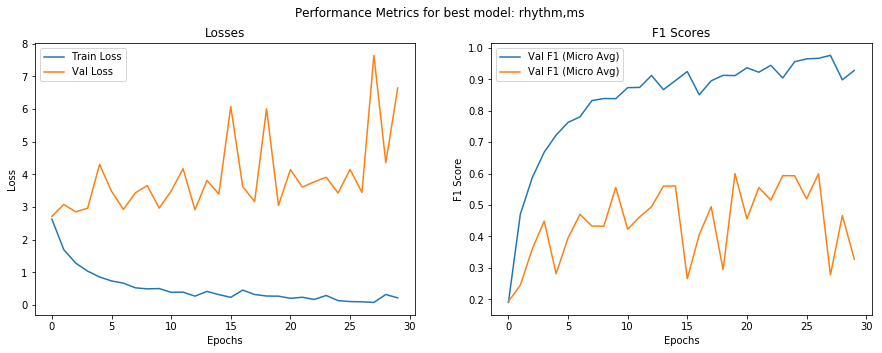

In [7]:
analyze("results_weight_decay")

## Performance

In [15]:
# Compute - macro F1 and micro F1 scores for the best models (on validation)
def make_table(results_dir):
    model_ids, confusion_matrices, metrics = read_results(results_dir)
    best_models = split_to_experiments(model_ids, metrics)
    
    
    rows = []
    for name, model_id in best_models.items():

        epoch_metrics = metrics[model_id]
        epoch_val_f1_micro = list(map(lambda _: _["val"]["micro avg"]["f1-score"], epoch_metrics))
        epoch_val_f1_macro = list(map(lambda _: _["val"]["macro avg"]["f1-score"], epoch_metrics))
        
        # best model is selected based on micro f1
        best_epoch = np.argmax(epoch_val_f1_micro)
        
        rows.append({
            "model": name,
            "f1_macro": epoch_val_f1_macro[best_epoch],
            "f1_micro": epoch_val_f1_micro[best_epoch],
            "model_id": model_id
        })
        
        
    
    return pd.DataFrame(rows)

df = make_table("results_no_weight_decay")
df["weight_decay"] = False

df_ = make_table("results_weight_decay")
df_["weight_decay"] = True

tab = pd.concat((df, df_))
tab.sort_values("f1_micro", inplace=True, ascending=False)
tab

Best model for audio,raw is : audioTrue_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.651027027027027
Best model for audio,ms is : audioTrue_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.696
Best model for rhythm,raw is : audioFalse_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6637837837837838
Best model for rhythm,ms is : audioFalse_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6408648648648648
Best model for audio,raw is : audioTrue_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6566486486486487
Best model for audio,ms is : audioTrue_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6964324324324325
Best model for rhythm,raw is : audioFalse_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6371891891891892
Best model for rhythm,ms is : audioFalse_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6


,f1_macro,f1_micro,model,model_id,weight_decay
1,0.708548,0.696432,"audio,ms",audioTrue_batch-normTrue_featuresms_learning-r...,True
1,0.703560,0.696000,"audio,ms",audioTrue_batch-normTrue_featuresms_learning-r...,False
2,0.673400,0.663784,"rhythm,raw",audioFalse_batch-normTrue_featuresraw_learning...,False
0,0.664227,0.656649,"audio,raw",audioTrue_batch-normTrue_featuresraw_learning-...,True
0,0.660458,0.651027,"audio,raw",audioTrue_batch-normTrue_featuresraw_learning-...,False
3,0.652110,0.640865,"rhythm,ms",audioFalse_batch-normTrue_featuresms_learning-...,False
2,0.646217,0.637189,"rhythm,raw",audioFalse_batch-normTrue_featuresraw_learning...,True
3,0.608261,0.600000,"rhythm,ms",audioFalse_batch-normTrue_featuresms_learning-...,True


## Diagnostic Classifiers

For each best model:
Find out the F1 scores for each of the meta data we captured

In [18]:
def diagnose(results_dir):
    model_ids, confusion_matrices, metrics = read_results(results_dir)
    best_models = split_to_experiments(model_ids, metrics)
    
    rows = []
    for name, model_id in best_models.items():
        with open(os.path.join(results_dir, model_id, "diag_train_results.json")) as reader:
            diag_train = json.load(reader)
        
        with open(os.path.join(results_dir, model_id, "diag_val_results.json")) as reader:
            diag_val = json.load(reader)
    
        splits = {
            "val": diag_val,
            "train": diag_train
        }
        for split, diag in splits.items():
            for meta_key in diag_train:
                rows.append({
                    "name": name,
                    "meta_data": meta_key,
#                     "best_model_id": model_id,
                    "split": split,
                    "test_f1_micro": diag[meta_key]["test"]["micro avg"]["f1-score"],
                    "test_precision_micro": diag[meta_key]["test"]["micro avg"]["precision"],
                    "test_recall_micro": diag[meta_key]["test"]["micro avg"]["recall"],
                    "test_f1_macro": diag[meta_key]["test"]["macro avg"]["f1-score"],
                    "test_precision_macro": diag[meta_key]["test"]["macro avg"]["precision"],
                    "test_recall_macro": diag[meta_key]["test"]["macro avg"]["recall"]
                })
        
    
    df = pd.DataFrame(rows)
    df.to_csv(f"{results_dir}_diagnostics.csv", index=False)
    
    return df
      
diagnose("results_no_weight_decay").sort_values(["name", "meta_data", "split"])

Best model for audio,raw is : audioTrue_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.651027027027027
Best model for audio,ms is : audioTrue_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.696
Best model for rhythm,raw is : audioFalse_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6637837837837838
Best model for rhythm,ms is : audioFalse_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6408648648648648


,meta_data,name,split,test_f1_macro,test_f1_micro,test_precision_macro,test_precision_micro,test_recall_macro,test_recall_micro
10,author_id,"audio,ms",train,0.970991,0.981260,0.980897,0.981260,0.965771,0.981260
7,author_id,"audio,ms",val,0.837993,0.913514,0.868968,0.913514,0.836594,0.913514
11,book_id,"audio,ms",train,0.861982,0.905258,0.881786,0.905258,0.855838,0.905258
8,book_id,"audio,ms",val,0.676062,0.835676,0.697319,0.835676,0.695058,0.835676
9,gender,"audio,ms",train,0.988520,0.988548,0.988423,0.988548,0.988625,0.988548
6,gender,"audio,ms",val,0.980375,0.980541,0.980187,0.980541,0.980572,0.980541
4,author_id,"audio,raw",train,0.803619,0.885476,0.812039,0.885476,0.803664,0.885476
1,author_id,"audio,raw",val,0.602773,0.776216,0.621177,0.776216,0.613814,0.776216
3,book_id,"audio,raw",train,0.630203,0.783967,0.649040,0.783967,0.649353,0.783967
0,book_id,"audio,raw",val,0.421581,0.670270,0.410620,0.670270,0.472496,0.670270


In [19]:
diagnose("results_weight_decay").sort_values(["name", "meta_data", "split"])

Best model for audio,raw is : audioTrue_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6566486486486487
Best model for audio,ms is : audioTrue_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6964324324324325
Best model for rhythm,raw is : audioFalse_batch-normTrue_featuresraw_learning-rate0.001, with a F1 of 0.6371891891891892
Best model for rhythm,ms is : audioFalse_batch-normTrue_featuresms_learning-rate0.001, with a F1 of 0.6


,meta_data,name,split,test_f1_macro,test_f1_micro,test_precision_macro,test_precision_micro,test_recall_macro,test_recall_micro
10,author_id,"audio,ms",train,0.972548,0.976575,0.975205,0.976575,0.972181,0.976575
7,author_id,"audio,ms",val,0.855190,0.921081,0.874352,0.921081,0.855619,0.921081
9,book_id,"audio,ms",train,0.836919,0.910984,0.849675,0.910984,0.833522,0.910984
6,book_id,"audio,ms",val,0.721537,0.855135,0.750640,0.855135,0.735583,0.855135
11,gender,"audio,ms",train,0.986463,0.986465,0.986515,0.986465,0.986430,0.986465
8,gender,"audio,ms",val,0.988101,0.988108,0.988187,0.988108,0.988036,0.988108
3,author_id,"audio,raw",train,0.803622,0.890161,0.813907,0.890161,0.803163,0.890161
0,author_id,"audio,raw",val,0.594758,0.763243,0.596472,0.763243,0.619000,0.763243
5,book_id,"audio,raw",train,0.604012,0.765226,0.608164,0.765226,0.622319,0.765226
2,book_id,"audio,raw",val,0.399901,0.684324,0.409026,0.684324,0.431015,0.684324
